# Shooting Matrices

Three matrix visualizations analyzing Bulls shooting patterns:

1. **FGM vs FGA Matrix** - Volume vs accuracy comparison
2. **Rim vs Three Matrix** - Shot selection analysis (paint vs perimeter)
3. **3P% vs 3PA Matrix** - Three-point value assessment

In [1]:
import sys
from pathlib import Path

# Add parent directory to path so we can import bulls
sys.path.insert(0, str(Path().absolute().parent))

from bulls import data, viz
from bulls.config import BULLS_TEAM_ID, CURRENT_SEASON
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

%matplotlib inline

## Reusable Matrix Visualization Helper

This function creates a quadrant matrix with player headshots, customizable axes and quadrant labels.

In [2]:
# Bulls colors
BULLS_RED = (206, 17, 65)
GREEN = (0, 128, 0)
RED_COLOR = (200, 50, 50)

def _adjust_positions_for_overlap(positions, min_distance=1.0, iterations=50):
    """Adjust positions to reduce overlap between headshots."""
    positions = [[p[0], p[1]] for p in positions]
    
    for _ in range(iterations):
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                dx = positions[j][0] - positions[i][0]
                dy = positions[j][1] - positions[i][1]
                dist = np.sqrt(dx**2 + dy**2)
                
                if dist < min_distance and dist > 0:
                    force = (min_distance - dist) * 0.3
                    dx_norm = dx / dist
                    dy_norm = dy / dist
                    
                    positions[i][0] -= dx_norm * force
                    positions[i][1] -= dy_norm * force
                    positions[j][0] += dx_norm * force
                    positions[j][1] += dy_norm * force
    
    return [(p[0], p[1]) for p in positions]


def shooting_matrix(
    players_data,
    x_key,
    y_key,
    x_label,
    y_label,
    title,
    x_threshold,
    y_threshold,
    quadrant_labels,  # dict with 'top_right', 'top_left', 'bottom_right', 'bottom_left'
    figsize=(12, 10),
    show_names=True,
):
    """
    Create a matrix visualization with player headshots.
    
    Args:
        players_data: List of dicts with player_id, name, and x_key/y_key values
        x_key: Key for x-axis value in players_data
        y_key: Key for y-axis value in players_data
        x_label: Label for x-axis
        y_label: Label for y-axis
        title: Chart title
        x_threshold: Vertical line threshold (league avg or midpoint)
        y_threshold: Horizontal line threshold
        quadrant_labels: Dict with keys 'top_right', 'top_left', 'bottom_right', 'bottom_left'
        figsize: Figure size tuple
        show_names: Whether to show player names below headshots
    
    Returns:
        matplotlib Figure
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    if not players_data:
        ax.text(0.5, 0.5, 'No player data available',
                ha='center', va='center', fontsize=14,
                transform=ax.transAxes)
        ax.set_title(title, fontsize=18, fontweight='bold')
        return fig
    
    # Extract data points
    x_vals = [p.get(x_key, 0) for p in players_data]
    y_vals = [p.get(y_key, 0) for p in players_data]
    
    # Calculate axis ranges with padding
    x_padding = (max(x_vals) - min(x_vals)) * 0.15 if len(x_vals) > 1 else 2
    y_padding = (max(y_vals) - min(y_vals)) * 0.15 if len(y_vals) > 1 else 5
    
    x_min = min(x_vals) - x_padding if x_vals else 0
    x_max = max(x_vals) + x_padding if x_vals else 20
    y_min = min(y_vals) - y_padding if y_vals else 0
    y_max = max(y_vals) + y_padding if y_vals else 20
    
    # Ensure thresholds are visible
    x_min = min(x_min, x_threshold - 2)
    x_max = max(x_max, x_threshold + 2)
    y_min = min(y_min, y_threshold - 5)
    y_max = max(y_max, y_threshold + 5)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Draw quadrant dividers
    ax.axhline(y=y_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1.5, zorder=1)
    ax.axvline(x=x_threshold, color='gray', linestyle='--', alpha=0.7, linewidth=1.5, zorder=1)
    
    # Add quadrant labels
    label_style = dict(fontsize=12, fontweight='bold', alpha=0.4, ha='center', va='center')
    
    # Top-right
    ax.text(
        x_max - (x_max - x_threshold) * 0.5,
        y_max - (y_max - y_threshold) * 0.15,
        quadrant_labels.get('top_right', ''),
        color=tuple(c / 255 for c in GREEN),
        **label_style,
    )
    
    # Top-left
    ax.text(
        x_min + (x_threshold - x_min) * 0.5,
        y_max - (y_max - y_threshold) * 0.15,
        quadrant_labels.get('top_left', ''),
        color=tuple(c / 255 for c in GREEN),
        **label_style,
    )
    
    # Bottom-right
    ax.text(
        x_max - (x_max - x_threshold) * 0.5,
        y_min + (y_threshold - y_min) * 0.15,
        quadrant_labels.get('bottom_right', ''),
        color=tuple(c / 255 for c in RED_COLOR),
        **label_style,
    )
    
    # Bottom-left
    ax.text(
        x_min + (x_threshold - x_min) * 0.5,
        y_min + (y_threshold - y_min) * 0.15,
        quadrant_labels.get('bottom_left', ''),
        color='gray',
        **label_style,
    )
    
    # Prepare positions and adjust for overlap
    positions = list(zip(x_vals, y_vals))
    x_range = x_max - x_min
    y_range = y_max - y_min
    min_dist = min(x_range, y_range) * 0.08
    adjusted_positions = _adjust_positions_for_overlap(positions, min_distance=min_dist)
    
    # Place player headshots
    for i, player in enumerate(players_data):
        x, y = adjusted_positions[i]
        player_id = player.get('player_id')
        name = player.get('name', 'Unknown')
        
        # Fetch headshot
        headshot_img = None
        if player_id:
            try:
                headshot_img = data.get_player_headshot(player_id, size=(80, 80))
            except Exception:
                pass
        
        if headshot_img is not None:
            img_array = np.array(headshot_img)
            im = OffsetImage(img_array, zoom=0.5)
            ab = AnnotationBbox(
                im, (x, y),
                frameon=True,
                bboxprops=dict(
                    boxstyle='round,pad=0.2',
                    facecolor='white',
                    edgecolor=tuple(c / 255 for c in BULLS_RED),
                    linewidth=2,
                ),
                zorder=5,
            )
            ax.add_artist(ab)
        else:
            # Fallback: draw a circle with initials
            initials = ''.join(word[0] for word in name.split()[:2]).upper()
            circle = plt.Circle(
                (x, y),
                radius=min_dist * 0.4,
                facecolor='white',
                edgecolor=tuple(c / 255 for c in BULLS_RED),
                linewidth=2,
                zorder=5,
            )
            ax.add_patch(circle)
            ax.text(x, y, initials, ha='center', va='center',
                    fontsize=10, fontweight='bold', zorder=6)
        
        # Add player first name below headshot
        if show_names:
            first_name = name.split()[0] if name else ''
            name_y_offset = min_dist * 0.7
            ax.text(
                x, y - name_y_offset,
                first_name,
                ha='center', va='top',
                fontsize=8, fontweight='bold',
                zorder=6,
            )
    
    # Labels and styling
    ax.set_xlabel(x_label, fontsize=12, fontweight='bold')
    ax.set_ylabel(y_label, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, zorder=0)
    
    plt.tight_layout()
    return fig

## Fetch Data

We need two data sources:
1. **Roster efficiency** for FGM/FGA data from box scores
2. **Team shots** for zone-based analysis (rim vs three)

In [3]:
# Configuration
LAST_N_GAMES = 10
MIN_FGA = 5.0
MIN_GAMES = 6  # At least 60% of games

print(f"Fetching data for last {LAST_N_GAMES} games...")
print(f"Filters: min {MIN_FGA} FGA/game, min {MIN_GAMES} games played\n")

Fetching data for last 10 games...
Filters: min 5.0 FGA/game, min 6 games played



In [4]:
# Get team shots for zone analysis
team_shots = data.get_team_shots(
    team_id=BULLS_TEAM_ID,
    season=CURRENT_SEASON,
    last_n_games=LAST_N_GAMES,
)

print(f"Loaded {len(team_shots)} shots")
if not team_shots.empty:
    print(f"Zones: {team_shots['shot_zone'].unique().tolist()}")

Loaded 895 shots
Zones: ['Above the Break 3', 'Restricted Area', 'In The Paint (Non-RA)', 'Left Corner 3', 'Mid-Range', 'Right Corner 3']


In [5]:
# Get box score data for FGM/FGA
# Use get_roster_efficiency which already aggregates box score data
roster_efficiency = data.get_roster_efficiency(
    last_n_games=LAST_N_GAMES,
    min_fga=MIN_FGA,
    season=CURRENT_SEASON,
)

# Filter to players with enough games
roster_efficiency = [p for p in roster_efficiency if p['games'] >= MIN_GAMES]

print(f"Found {len(roster_efficiency)} players meeting criteria")

Found 8 players meeting criteria


---

## 1. FGM vs FGA Matrix

Compares **volume** (FGA per game) with **production** (FGM per game).

**Quadrants:**
- **HIGH VOLUME SCORERS** (top-right): High FGA + high FGM (offensive focal points)
- **EFFICIENT FINISHERS** (top-left): Low FGA + high FGM (quality over quantity)
- **DEVELOPING** (bottom-right): High FGA + low FGM (learning to score efficiently)
- **ROLE PLAYERS** (bottom-left): Low FGA + low FGM (not primary scoring options)

In [6]:
# Calculate FGM per game from box score data
# We need to fetch individual box scores to get FGM data

# Get unique game IDs from team shots
game_ids = team_shots['game_id'].unique().tolist() if not team_shots.empty else []

# Aggregate FGM and FGA per player
player_fg_stats = {}

for game_id in game_ids:
    box = data.get_box_score(game_id)
    if box.empty:
        continue
    
    for _, row in box.iterrows():
        player_id = row.get('personId') or row.get('playerId')
        if player_id is None:
            continue
        
        player_id = int(player_id)
        name = row.get('name', f"{row.get('firstName', '')} {row.get('familyName', '')}")
        
        if player_id not in player_fg_stats:
            player_fg_stats[player_id] = {
                'player_id': player_id,
                'name': name,
                'games': 0,
                'fgm': 0,
                'fga': 0,
            }
        
        player_fg_stats[player_id]['games'] += 1
        player_fg_stats[player_id]['fgm'] += int(row.get('fieldGoalsMade', 0) or 0)
        player_fg_stats[player_id]['fga'] += int(row.get('fieldGoalsAttempted', 0) or 0)

# Convert to list with per-game averages
fgm_fga_data = []
for pid, stats in player_fg_stats.items():
    if stats['games'] < MIN_GAMES:
        continue
    
    fga_per_game = stats['fga'] / stats['games']
    if fga_per_game < MIN_FGA:
        continue
    
    fgm_per_game = stats['fgm'] / stats['games']
    
    fgm_fga_data.append({
        'player_id': pid,
        'name': stats['name'],
        'fga_per_game': round(fga_per_game, 1),
        'fgm_per_game': round(fgm_per_game, 1),
        'games': stats['games'],
    })

# Sort by FGA
fgm_fga_data.sort(key=lambda x: x['fga_per_game'], reverse=True)

print(f"FGM vs FGA Data ({len(fgm_fga_data)} players):\n")
for p in fgm_fga_data:
    print(f"{p['name']:20} | {p['fgm_per_game']:4.1f} FGM/G | {p['fga_per_game']:4.1f} FGA/G | {p['games']} games")

FGM vs FGA Data (8 players):

Nikola Vučević       |  7.7 FGM/G | 14.6 FGA/G | 10 games
Coby White           |  6.1 FGM/G | 12.4 FGA/G | 9 games
Matas Buzelis        |  5.4 FGM/G | 12.3 FGA/G | 10 games
Ayo Dosunmu          |  6.1 FGM/G | 11.2 FGA/G | 10 games
Jalen Smith          |  4.6 FGM/G |  9.6 FGA/G | 9 games
Tre Jones            |  5.2 FGM/G |  8.1 FGA/G | 8 games
Kevin Huerter        |  3.3 FGM/G |  7.8 FGA/G | 10 games
Isaac Okoro          |  3.1 FGM/G |  6.5 FGA/G | 10 games


Thresholds: FGA = 10.4, FGM = 5.3


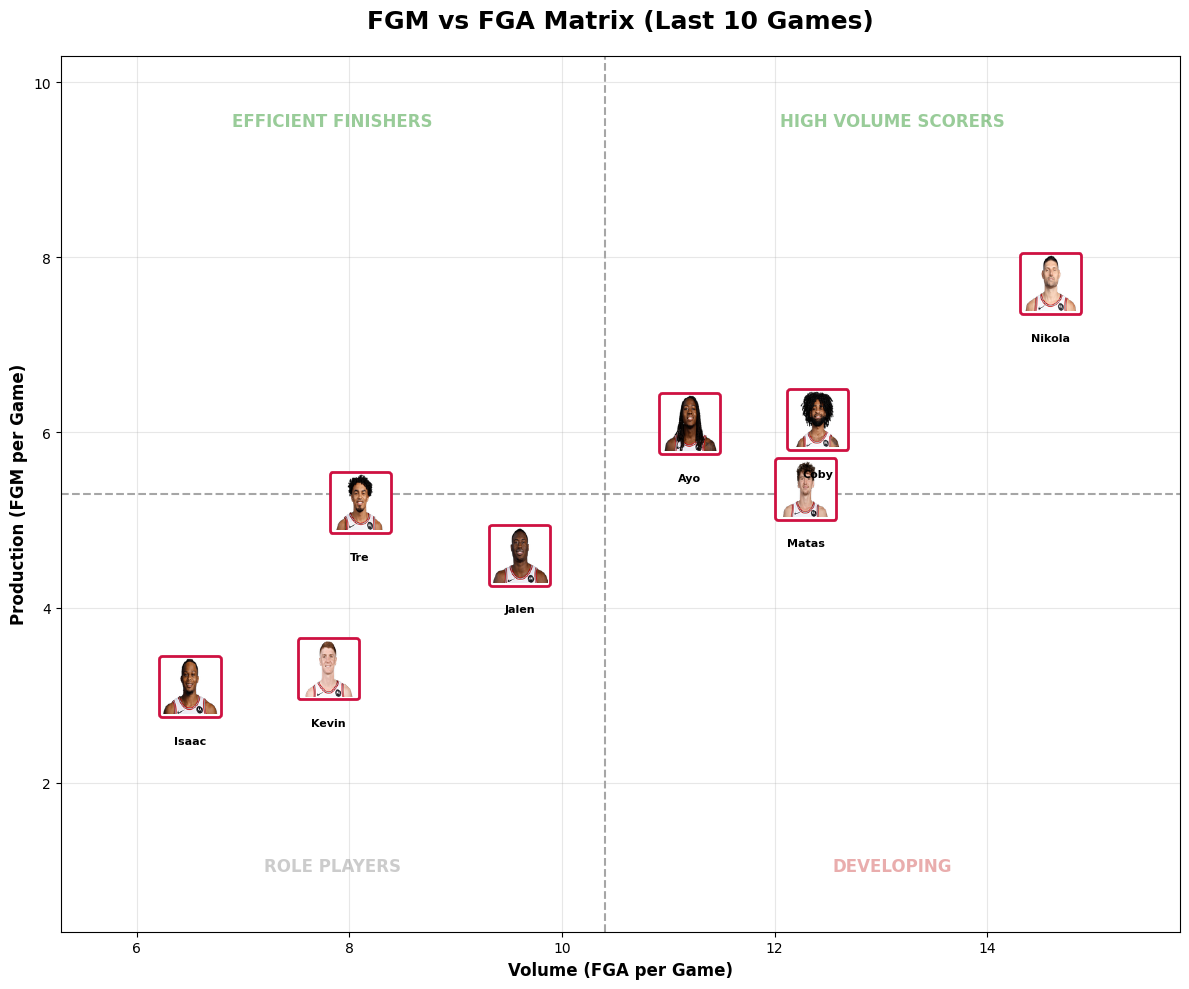

In [7]:
# Calculate thresholds (median of the data)
if fgm_fga_data:
    fga_values = [p['fga_per_game'] for p in fgm_fga_data]
    fgm_values = [p['fgm_per_game'] for p in fgm_fga_data]
    fga_threshold = np.median(fga_values)
    fgm_threshold = np.median(fgm_values)
else:
    fga_threshold = 10.0
    fgm_threshold = 4.0

print(f"Thresholds: FGA = {fga_threshold:.1f}, FGM = {fgm_threshold:.1f}")

fig = shooting_matrix(
    fgm_fga_data,
    x_key='fga_per_game',
    y_key='fgm_per_game',
    x_label='Volume (FGA per Game)',
    y_label='Production (FGM per Game)',
    title=f'FGM vs FGA Matrix (Last {LAST_N_GAMES} Games)',
    x_threshold=fga_threshold,
    y_threshold=fgm_threshold,
    quadrant_labels={
        'top_right': 'HIGH VOLUME SCORERS',
        'top_left': 'EFFICIENT FINISHERS',
        'bottom_right': 'DEVELOPING',
        'bottom_left': 'ROLE PLAYERS',
    },
)
plt.show()

---

## 2. Rim vs Three Matrix

Analyzes shot selection by comparing **paint attempts** (Restricted Area) with **three-point attempts**.

**Quadrants:**
- **MODERN SCORERS** (top-right): High rim + high 3PA (complete offensive game)
- **SLASHERS** (top-left): High rim + low 3PA (attack the basket)
- **SNIPERS** (bottom-right): Low rim + high 3PA (perimeter specialists)
- **MID-RANGE** (bottom-left): Low rim + low 3PA (traditional/mid-range players)

In [8]:
# Calculate rim and three-point attempts per game by player
if not team_shots.empty and 'player_id' in team_shots.columns:
    # Group shots by player
    player_shots = team_shots.groupby('player_id').agg({
        'player_name': 'first',
        'game_id': 'nunique',
        'shot_zone': list,
        'shot_type': list,
    }).reset_index()
    
    rim_three_data = []
    
    for _, row in player_shots.iterrows():
        player_id = int(row['player_id'])
        name = row['player_name'] if row['player_name'] else 'Unknown'
        games = row['game_id']
        
        if games < MIN_GAMES:
            continue
        
        zones = row['shot_zone']
        types = row['shot_type']
        
        # Count restricted area and 3PT attempts
        rim_attempts = sum(1 for z in zones if z == 'Restricted Area')
        three_attempts = sum(1 for t in types if t == '3PT')
        total_fga = len(zones)
        
        # Filter by minimum FGA
        fga_per_game = total_fga / games
        if fga_per_game < MIN_FGA:
            continue
        
        rim_per_game = rim_attempts / games
        three_per_game = three_attempts / games
        
        rim_three_data.append({
            'player_id': player_id,
            'name': name,
            'rim_per_game': round(rim_per_game, 1),
            'three_per_game': round(three_per_game, 1),
            'fga_per_game': round(fga_per_game, 1),
            'games': games,
        })
    
    # Sort by total FGA
    rim_three_data.sort(key=lambda x: x['fga_per_game'], reverse=True)
    
    print(f"Rim vs Three Data ({len(rim_three_data)} players):\n")
    for p in rim_three_data:
        print(f"{p['name']:20} | {p['rim_per_game']:4.1f} Rim/G | {p['three_per_game']:4.1f} 3PA/G | {p['games']} games")
else:
    rim_three_data = []
    print("No shot data available")

Rim vs Three Data (8 players):

Nikola Vučević       |  3.4 Rim/G |  4.1 3PA/G | 10 games
Coby White           |  3.4 Rim/G |  8.5 3PA/G | 8 games
Matas Buzelis        |  4.1 Rim/G |  6.5 3PA/G | 10 games
Ayo Dosunmu          |  4.5 Rim/G |  4.9 3PA/G | 10 games
Jalen Smith          |  2.9 Rim/G |  5.2 3PA/G | 9 games
Tre Jones            |  4.1 Rim/G |  2.2 3PA/G | 8 games
Kevin Huerter        |  1.4 Rim/G |  4.5 3PA/G | 10 games
Isaac Okoro          |  2.6 Rim/G |  3.2 3PA/G | 10 games


Thresholds: 3PA = 4.7, Rim = 3.4


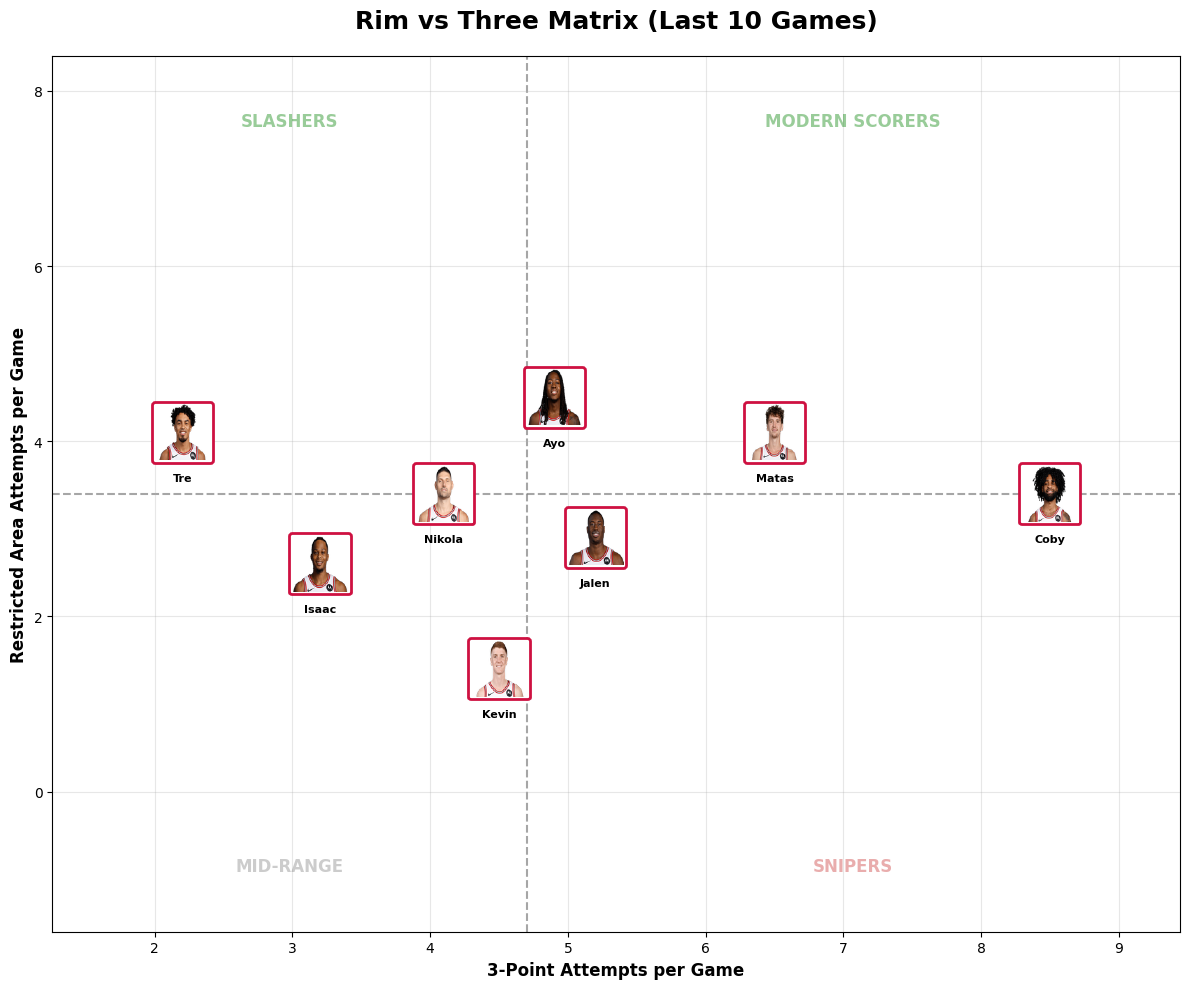

In [9]:
# Calculate thresholds
if rim_three_data:
    three_values = [p['three_per_game'] for p in rim_three_data]
    rim_values = [p['rim_per_game'] for p in rim_three_data]
    three_threshold = np.median(three_values)
    rim_threshold = np.median(rim_values)
else:
    three_threshold = 3.0
    rim_threshold = 2.0

print(f"Thresholds: 3PA = {three_threshold:.1f}, Rim = {rim_threshold:.1f}")

fig = shooting_matrix(
    rim_three_data,
    x_key='three_per_game',
    y_key='rim_per_game',
    x_label='3-Point Attempts per Game',
    y_label='Restricted Area Attempts per Game',
    title=f'Rim vs Three Matrix (Last {LAST_N_GAMES} Games)',
    x_threshold=three_threshold,
    y_threshold=rim_threshold,
    quadrant_labels={
        'top_right': 'MODERN SCORERS',
        'top_left': 'SLASHERS',
        'bottom_right': 'SNIPERS',
        'bottom_left': 'MID-RANGE',
    },
)
plt.show()

---

## 3. 3P% vs 3PA Matrix

Evaluates three-point shooting **efficiency** vs **volume**.

**Quadrants:**
- **ELITE SHOOTERS** (top-right): High 3P% + high 3PA (best of both worlds)
- **SELECTIVE SNIPERS** (top-left): High 3P% + low 3PA (efficient but limited volume)
- **VOLUME SHOOTERS** (bottom-right): Low 3P% + high 3PA (quantity over quality)
- **LIMITED RANGE** (bottom-left): Low 3P% + low 3PA (not a three-point threat)

In [10]:
# Calculate 3P% and 3PA per game by player
if not team_shots.empty and 'player_id' in team_shots.columns:
    # Filter to only 3-point shots
    three_shots = team_shots[team_shots['shot_type'] == '3PT'].copy()
    
    if not three_shots.empty:
        player_three = three_shots.groupby('player_id').agg({
            'player_name': 'first',
            'game_id': 'nunique',
            'shot_made': ['sum', 'count'],
        })
        
        # Flatten column names
        player_three.columns = ['name', 'games', 'made', 'attempts']
        player_three = player_three.reset_index()
        
        three_pct_data = []
        
        for _, row in player_three.iterrows():
            player_id = int(row['player_id'])
            name = row['name'] if row['name'] else 'Unknown'
            games = row['games']
            made = row['made']
            attempts = row['attempts']
            
            if games < MIN_GAMES:
                continue
            
            three_per_game = attempts / games
            
            # Require at least 2 3PA per game for meaningful %
            if three_per_game < 2.0:
                continue
            
            three_pct = (made / attempts * 100) if attempts > 0 else 0
            
            three_pct_data.append({
                'player_id': player_id,
                'name': name,
                'three_pct': round(three_pct, 1),
                'three_per_game': round(three_per_game, 1),
                'made': made,
                'attempts': attempts,
                'games': games,
            })
        
        # Sort by 3PA
        three_pct_data.sort(key=lambda x: x['three_per_game'], reverse=True)
        
        print(f"3P% vs 3PA Data ({len(three_pct_data)} players):\n")
        for p in three_pct_data:
            print(f"{p['name']:20} | {p['three_pct']:5.1f}% | {p['three_per_game']:4.1f} 3PA/G | {p['made']}/{p['attempts']} | {p['games']} games")
    else:
        three_pct_data = []
        print("No 3-point shot data available")
else:
    three_pct_data = []
    print("No shot data available")

3P% vs 3PA Data (9 players):

Coby White           |  45.6% |  8.5 3PA/G | 31/68 | 8 games
Matas Buzelis        |  38.5% |  6.5 3PA/G | 25/65 | 10 games
Jalen Smith          |  38.3% |  5.2 3PA/G | 18/47 | 9 games
Ayo Dosunmu          |  51.0% |  4.9 3PA/G | 25/49 | 10 games
Kevin Huerter        |  28.9% |  4.5 3PA/G | 13/45 | 10 games
Nikola Vučević       |  31.7% |  4.1 3PA/G | 13/41 | 10 games
Isaac Okoro          |  34.4% |  3.2 3PA/G | 11/32 | 10 games
Patrick Williams     |  50.0% |  2.8 3PA/G | 11/22 | 8 games
Tre Jones            |  50.0% |  2.2 3PA/G | 9/18 | 8 games


Thresholds: 3PA = 4.5, 3P% = 36.0%


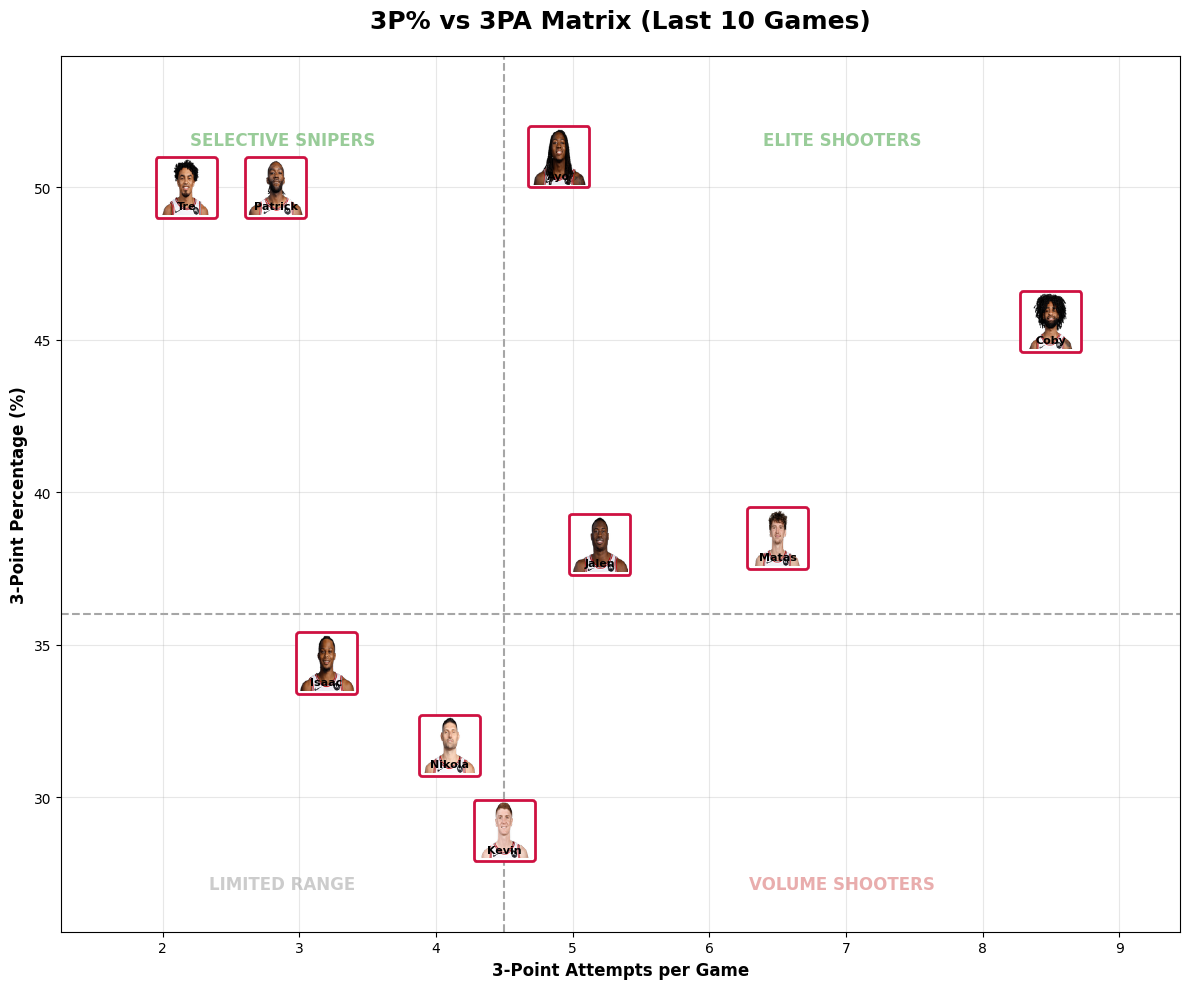

In [11]:
# Calculate thresholds (use league average for 3P% = 36%)
if three_pct_data:
    three_volume_values = [p['three_per_game'] for p in three_pct_data]
    three_volume_threshold = np.median(three_volume_values)
else:
    three_volume_threshold = 4.0

three_pct_threshold = 36.0  # League average 3P%

print(f"Thresholds: 3PA = {three_volume_threshold:.1f}, 3P% = {three_pct_threshold:.1f}%")

fig = shooting_matrix(
    three_pct_data,
    x_key='three_per_game',
    y_key='three_pct',
    x_label='3-Point Attempts per Game',
    y_label='3-Point Percentage (%)',
    title=f'3P% vs 3PA Matrix (Last {LAST_N_GAMES} Games)',
    x_threshold=three_volume_threshold,
    y_threshold=three_pct_threshold,
    quadrant_labels={
        'top_right': 'ELITE SHOOTERS',
        'top_left': 'SELECTIVE SNIPERS',
        'bottom_right': 'VOLUME SHOOTERS',
        'bottom_left': 'LIMITED RANGE',
    },
)
plt.show()

---

## Summary

These three matrices provide different perspectives on Bulls shooting:

| Matrix | X-Axis | Y-Axis | Key Insight |
|--------|--------|--------|-------------|
| FGM vs FGA | Volume (FGA/G) | Production (FGM/G) | Who converts their attempts? |
| Rim vs Three | 3-Point Attempts | Rim Attempts | What shot profile does each player have? |
| 3P% vs 3PA | 3-Point Volume | 3-Point Accuracy | Who are the reliable shooters? |